Name: Ashley Chen

GitHub username: ash54x

USC ID: 8562317194

1) Decision Trees as Interpretable Models

In [547]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from math import floor, sqrt
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

a. Load Data

In [548]:
#load data
df = pd.read_csv(
    '../data/diagnosis.data',
    header=None,
    encoding='utf-16',
    sep='\t',
    names=['Temperature','Nausea','Lumbar','Urine','Micturition','Urethra','Inflammation','Nephritis'],
    decimal=','
)

display(df)

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,Inflammation,Nephritis
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
115,41.4,no,yes,yes,no,yes,no,yes
116,41.5,no,no,no,no,no,no,no
117,41.5,yes,yes,no,yes,no,no,yes
118,41.5,no,yes,yes,no,yes,no,yes


b. Decision Tree

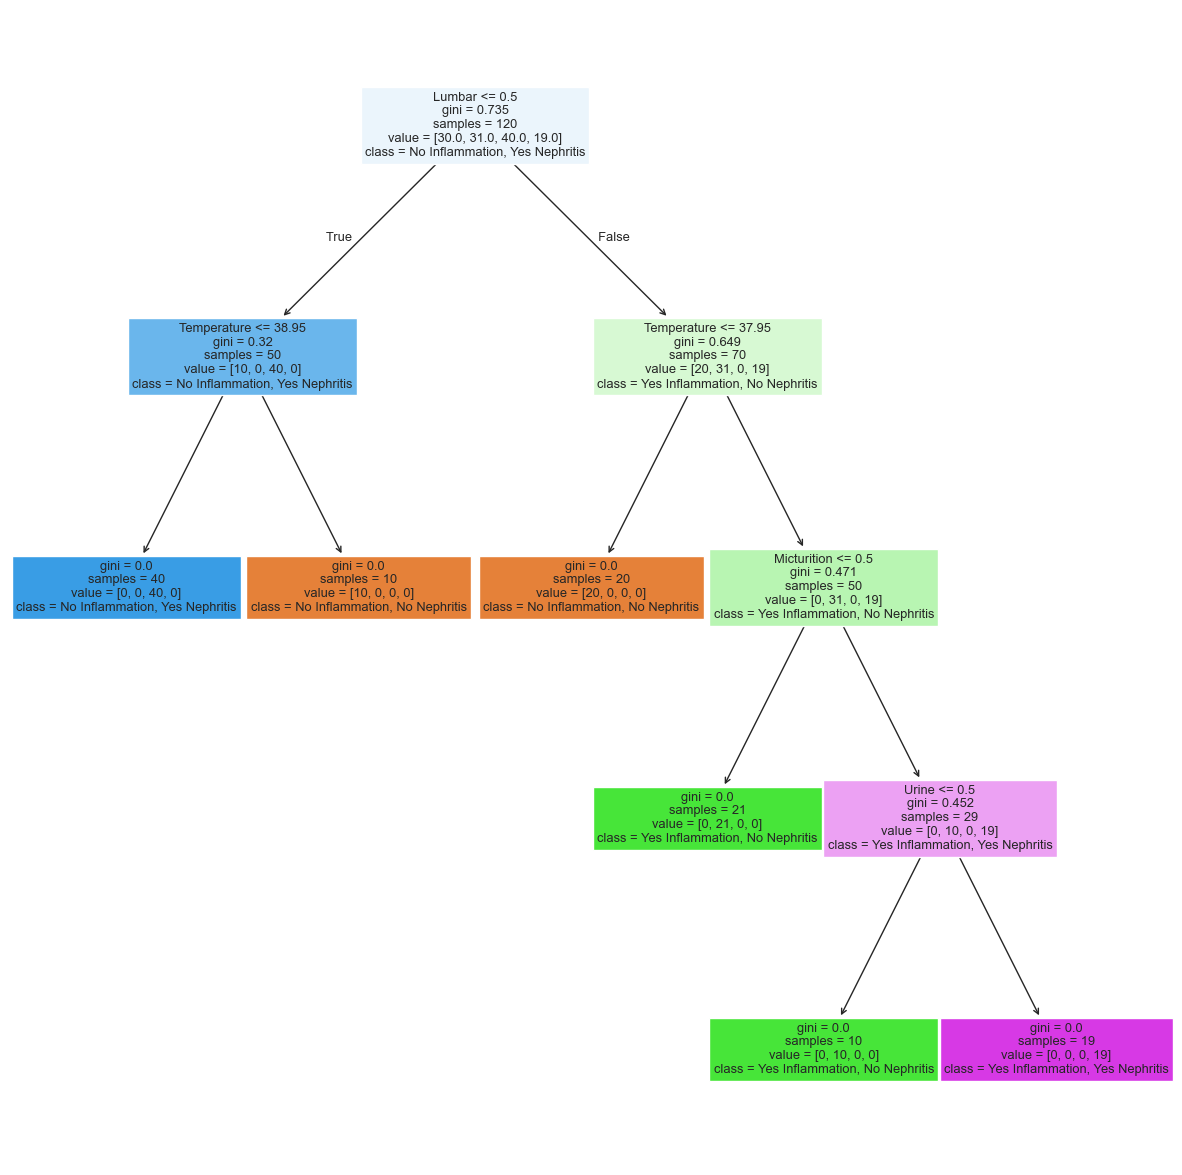

In [549]:
#convert categorical variables into numerical
df = df.replace({'yes': 1, 'no': 0})

df['Target'] = df['Inflammation'].astype(str) + df['Nephritis'].astype(str)
X = df[['Temperature', 'Nausea', 'Lumbar', 'Urine', 'Micturition', 'Urethra']]
y = df['Target']

#build a decision tree classifier
dt_model = DecisionTreeClassifier(random_state=69, min_samples_leaf=5)
dt_model.fit(X, y)

#visualize the decision tree
plt.figure(figsize=(15, 15))
tree.plot_tree(dt_model, feature_names=X.columns, 
               class_names=class_names, filled=True)
plt.show()

c. IF-THEN Rules

In [550]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))
    
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node] * tree_.weighted_n_node_samples[node]))
    
    recurse(0, 1)

tree_to_code(dt_model, list(X.columns))

def tree(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
  if Lumbar <= 0.5:
    if Temperature <= 38.95000076293945:
      return [[ 0.  0. 40.  0.]]
    else:  # if Temperature > 38.95000076293945
      return [[10.  0.  0.  0.]]
  else:  # if Lumbar > 0.5
    if Temperature <= 37.95000076293945:
      return [[20.  0.  0.  0.]]
    else:  # if Temperature > 37.95000076293945
      if Micturition <= 0.5:
        return [[ 0. 21.  0.  0.]]
      else:  # if Micturition > 0.5
        if Urine <= 0.5:
          return [[ 0. 10.  0.  0.]]
        else:  # if Urine > 0.5
          return [[ 0.  0.  0. 19.]]


d. Cost-Complexity Pruning

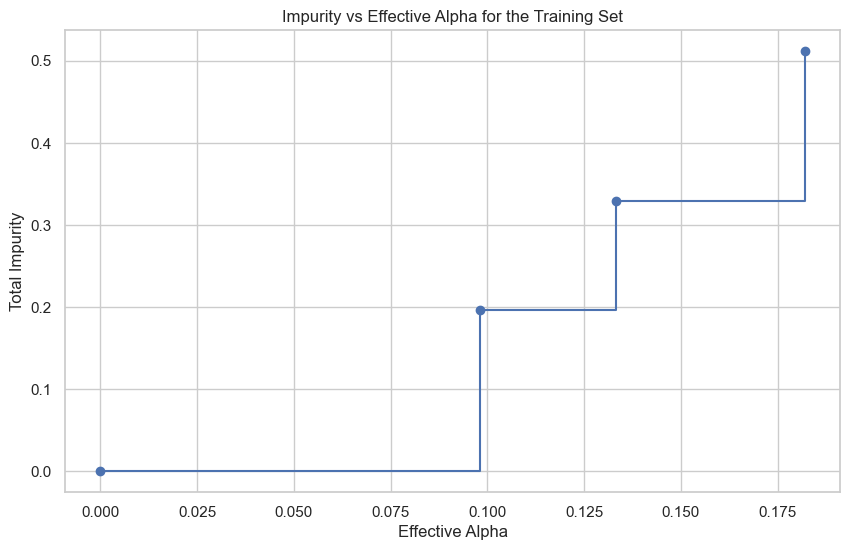

Best ccp_alpha found via cross-validation: 0.0


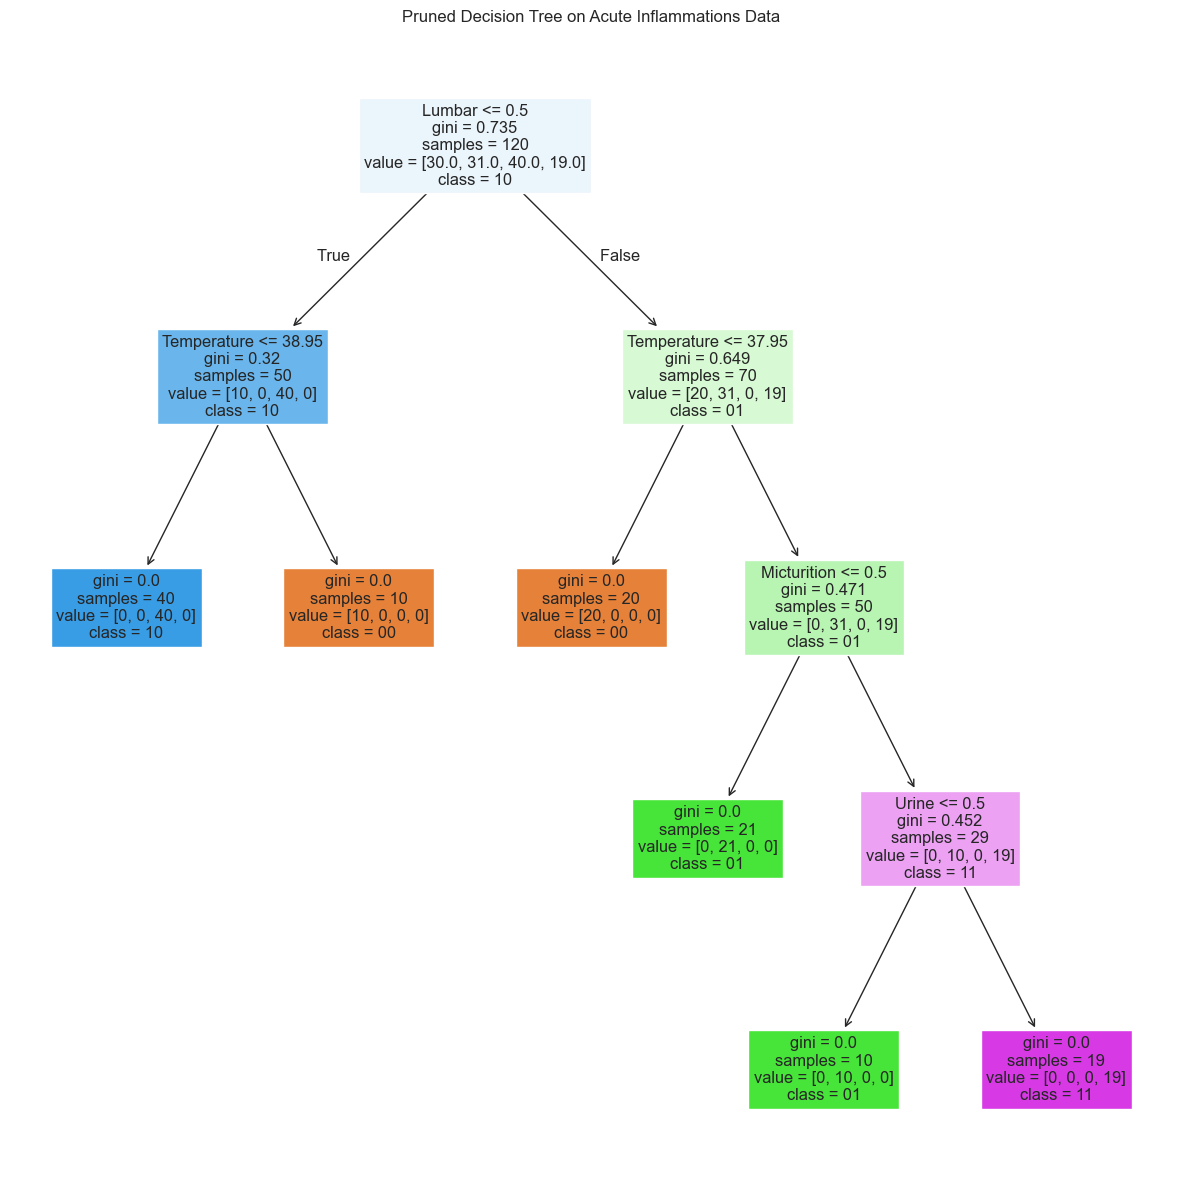

def tree(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
  if Lumbar <= 0.5:
    if Temperature <= 38.95000076293945:
      return [[ 0.  0. 40.  0.]]
    else:  # if Temperature > 38.95000076293945
      return [[10.  0.  0.  0.]]
  else:  # if Lumbar > 0.5
    if Temperature <= 37.95000076293945:
      return [[20.  0.  0.  0.]]
    else:  # if Temperature > 37.95000076293945
      if Micturition <= 0.5:
        return [[ 0. 21.  0.  0.]]
      else:  # if Micturition > 0.5
        if Urine <= 0.5:
          return [[ 0. 10.  0.  0.]]
        else:  # if Urine > 0.5
          return [[ 0.  0.  0. 19.]]


In [551]:
#get the effective alphas and corresponding impurities
path = dt_model.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#plot the relationship between alpha and total impurity
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective Alpha")
plt.ylabel("Total Impurity")
plt.title("Impurity vs Effective Alpha for the Training Set")
plt.show()

#set up a parameter grid over the effective alphas
param_grid = {'ccp_alpha': ccp_alphas}
dt = DecisionTreeClassifier(random_state=69, min_samples_leaf=5)
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X, y)
best_alpha = grid_search.best_params_['ccp_alpha']
print("Best ccp_alpha found via cross-validation:", best_alpha)

#train a new decision tree using the best alpha (pruned tree)
dt_pruned = DecisionTreeClassifier(random_state=69, min_samples_leaf=5, ccp_alpha=best_alpha)
dt_pruned.fit(X, y)

#plot the pruned decision tree
plt.figure(figsize=(15, 15))
tree.plot_tree(dt_pruned, feature_names=X.columns, 
               class_names=dt_pruned.classes_.astype(str), filled=True)
plt.title("Pruned Decision Tree on Acute Inflammations Data")
plt.show()

#convert the pruned decision tree to a set of IF-THEN rules
def tree_to_code(tree_model, feature_names):
    tree_ = tree_model.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))
    
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node] * tree_.weighted_n_node_samples[node]))
    
    recurse(0, 1)

#output the decision rules for the pruned tree
tree_to_code(dt_pruned, list(X.columns))


2) The LASSO and Boosting for Regression

a. Load Data

In [552]:
df = pd.read_csv(
    "../data/communities.data", 
    header=None, 
    names=['state','county','community','communityname','fold','population','householdsize','racepctblack','racePctWhite','racePctAsian','racePctHisp','agePct12t21','agePct12t29','agePct16t24','agePct65up','numbUrban','pctUrban','medIncome','pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst','pctWRetire','medFamInc','perCapInc','whitePerCap','blackPerCap','indianPerCap','AsianPerCap','OtherPerCap','HispPerCap','NumUnderPov','PctPopUnderPov','PctLess9thGrade','PctNotHSGrad','PctBSorMore','PctUnemployed','PctEmploy','PctEmplManu','PctEmplProfServ','PctOccupManu','PctOccupMgmtProf','MalePctDivorce','MalePctNevMarr','FemalePctDiv','TotalPctDiv','PersPerFam','PctFam2Par','PctKids2Par','PctYoungKids2Par','PctTeen2Par','PctWorkMomYoungKids','PctWorkMom','NumIlleg','PctIlleg','NumImmig','PctImmigRecent','PctImmigRec5','PctImmigRec8','PctImmigRec10','PctRecentImmig','PctRecImmig5','PctRecImmig8','PctRecImmig10','PctSpeakEnglOnly','PctNotSpeakEnglWell','PctLargHouseFam','PctLargHouseOccup','PersPerOccupHous','PersPerOwnOccHous','PersPerRentOccHous','PctPersOwnOccup','PctPersDenseHous','PctHousLess3BR','MedNumBR','HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','MedYrHousBuilt','PctHousNoPhone','PctWOFullPlumb','OwnOccLowQuart','OwnOccMedVal','OwnOccHiQuart','RentLowQ','RentMedian','RentHighQ','MedRent','MedRentPctHousInc','MedOwnCostPctInc','MedOwnCostPctIncNoMtg','NumInShelters','NumStreet','PctForeignBorn','PctBornSameState','PctSameHouse85','PctSameCity85','PctSameState85','LemasSwornFT','LemasSwFTPerPop','LemasSwFTFieldOps','LemasSwFTFieldPerPop','LemasTotalReq','LemasTotReqPerPop','PolicReqPerOffic','PolicPerPop','RacialMatchCommPol','PctPolicWhite','PctPolicBlack','PctPolicHisp','PctPolicAsian','PctPolicMinor','OfficAssgnDrugUnits','NumKindsDrugsSeiz','PolicAveOTWorked','LandArea','PopDens','PctUsePubTrans','PolicCars','PolicOperBudg','LemasPctPolicOnPatr','LemasGangUnitDeploy','LemasPctOfficDrugUn','PolicBudgPerPop','ViolentCrimesPerPop'],
    na_values='?'
)

display(df)

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


b. Clean data

In [553]:
#identify columns that are non-predictive
nonpredictive_cols = ['state','county','community','communityname','fold']

#separate features and target
target_col = 'ViolentCrimesPerPop'
feature_cols = [col for col in df.columns if col not in nonpredictive_cols + [target_col]]

#create a separate df for features
X_full = df[feature_cols]
y_full = df[target_col]

#replace missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_full) 
#convert back to df
X_imputed_df = pd.DataFrame(X_imputed, columns=feature_cols)

#reattach the target
df_imputed = pd.concat([X_imputed_df, y_full], axis=1)

#train/test split
df_train = df_imputed.iloc[:1495, :]
df_test  = df_imputed.iloc[1495:, :]

#final X_train, y_train, X_test, y_test
X_train = df_train[feature_cols].values
y_train = df_train[target_col].values
X_test = df_test[feature_cols].values
y_test = df_test[target_col].values

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1495, 122)
Test set shape: (499, 122)


c. Correlation Matrix

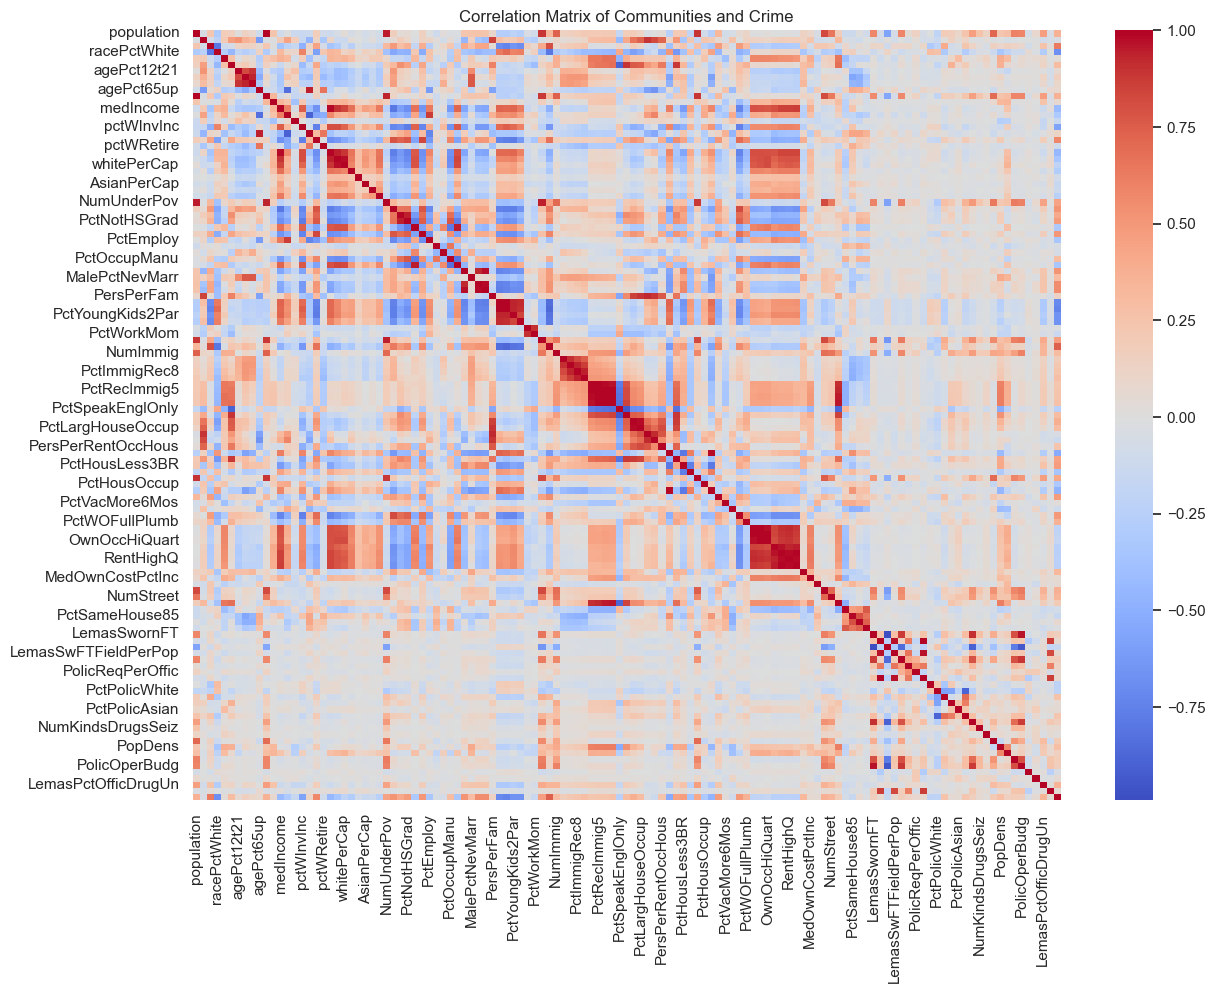

In [554]:
corr_matrix = df_imputed.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Communities and Crime")
plt.show()

d. Coefficient of Variation CV

In [555]:
train_df_features = df_train[feature_cols]

cv_values = {}
for col in feature_cols:
    series = train_df_features[col]
    mean_val = series.mean()
    std_val = series.std()
    if mean_val != 0:
        cv_values[col] = std_val / mean_val
    else:
        cv_values[col] = 0

display(cv_values)

{'population': 2.2411046245803816,
 'householdsize': 0.35579956640289406,
 'racepctblack': 1.428885418650282,
 'racePctWhite': 0.3302126634442842,
 'racePctAsian': 1.3590996841590066,
 'racePctHisp': 1.612091005228414,
 'agePct12t21': 0.36908311920951187,
 'agePct12t29': 0.2913148106352061,
 'agePct16t24': 0.500309911537721,
 'agePct65up': 0.41277597585122844,
 'numbUrban': 2.038461491915646,
 'pctUrban': 0.6433181716461012,
 'medIncome': 0.5919781653450648,
 'pctWWage': 0.32861405690159434,
 'pctWFarmSelf': 0.7018978730820067,
 'pctWInvInc': 0.3653345827441905,
 'pctWSocSec': 0.36071544651696696,
 'pctWPubAsst': 0.7062058943769397,
 'pctWRetire': 0.3454209567630025,
 'medFamInc': 0.540670153054935,
 'perCapInc': 0.5580794526579659,
 'whitePerCap': 0.5198284670247887,
 'blackPerCap': 0.5993405451897988,
 'indianPerCap': 0.818368126432771,
 'AsianPerCap': 0.6148655265869312,
 'OtherPerCap': 0.6732169975302165,
 'HispPerCap': 0.4840679504501614,
 'NumUnderPov': 2.3424431162181665,
 'PctP

e. Scatter plots and box plots


Top features by CV (k=11):
1. NumStreet: CV=4.293
2. NumInShelters: CV=3.471
3. NumIlleg: CV=3.059
4. NumImmig: CV=2.927
5. LemasPctOfficDrugUn: CV=2.553
6. NumUnderPov: CV=2.342
7. population: CV=2.241
8. numbUrban: CV=2.038
9. HousVacant: CV=1.968
10. LandArea: CV=1.645
11. racePctHisp: CV=1.612


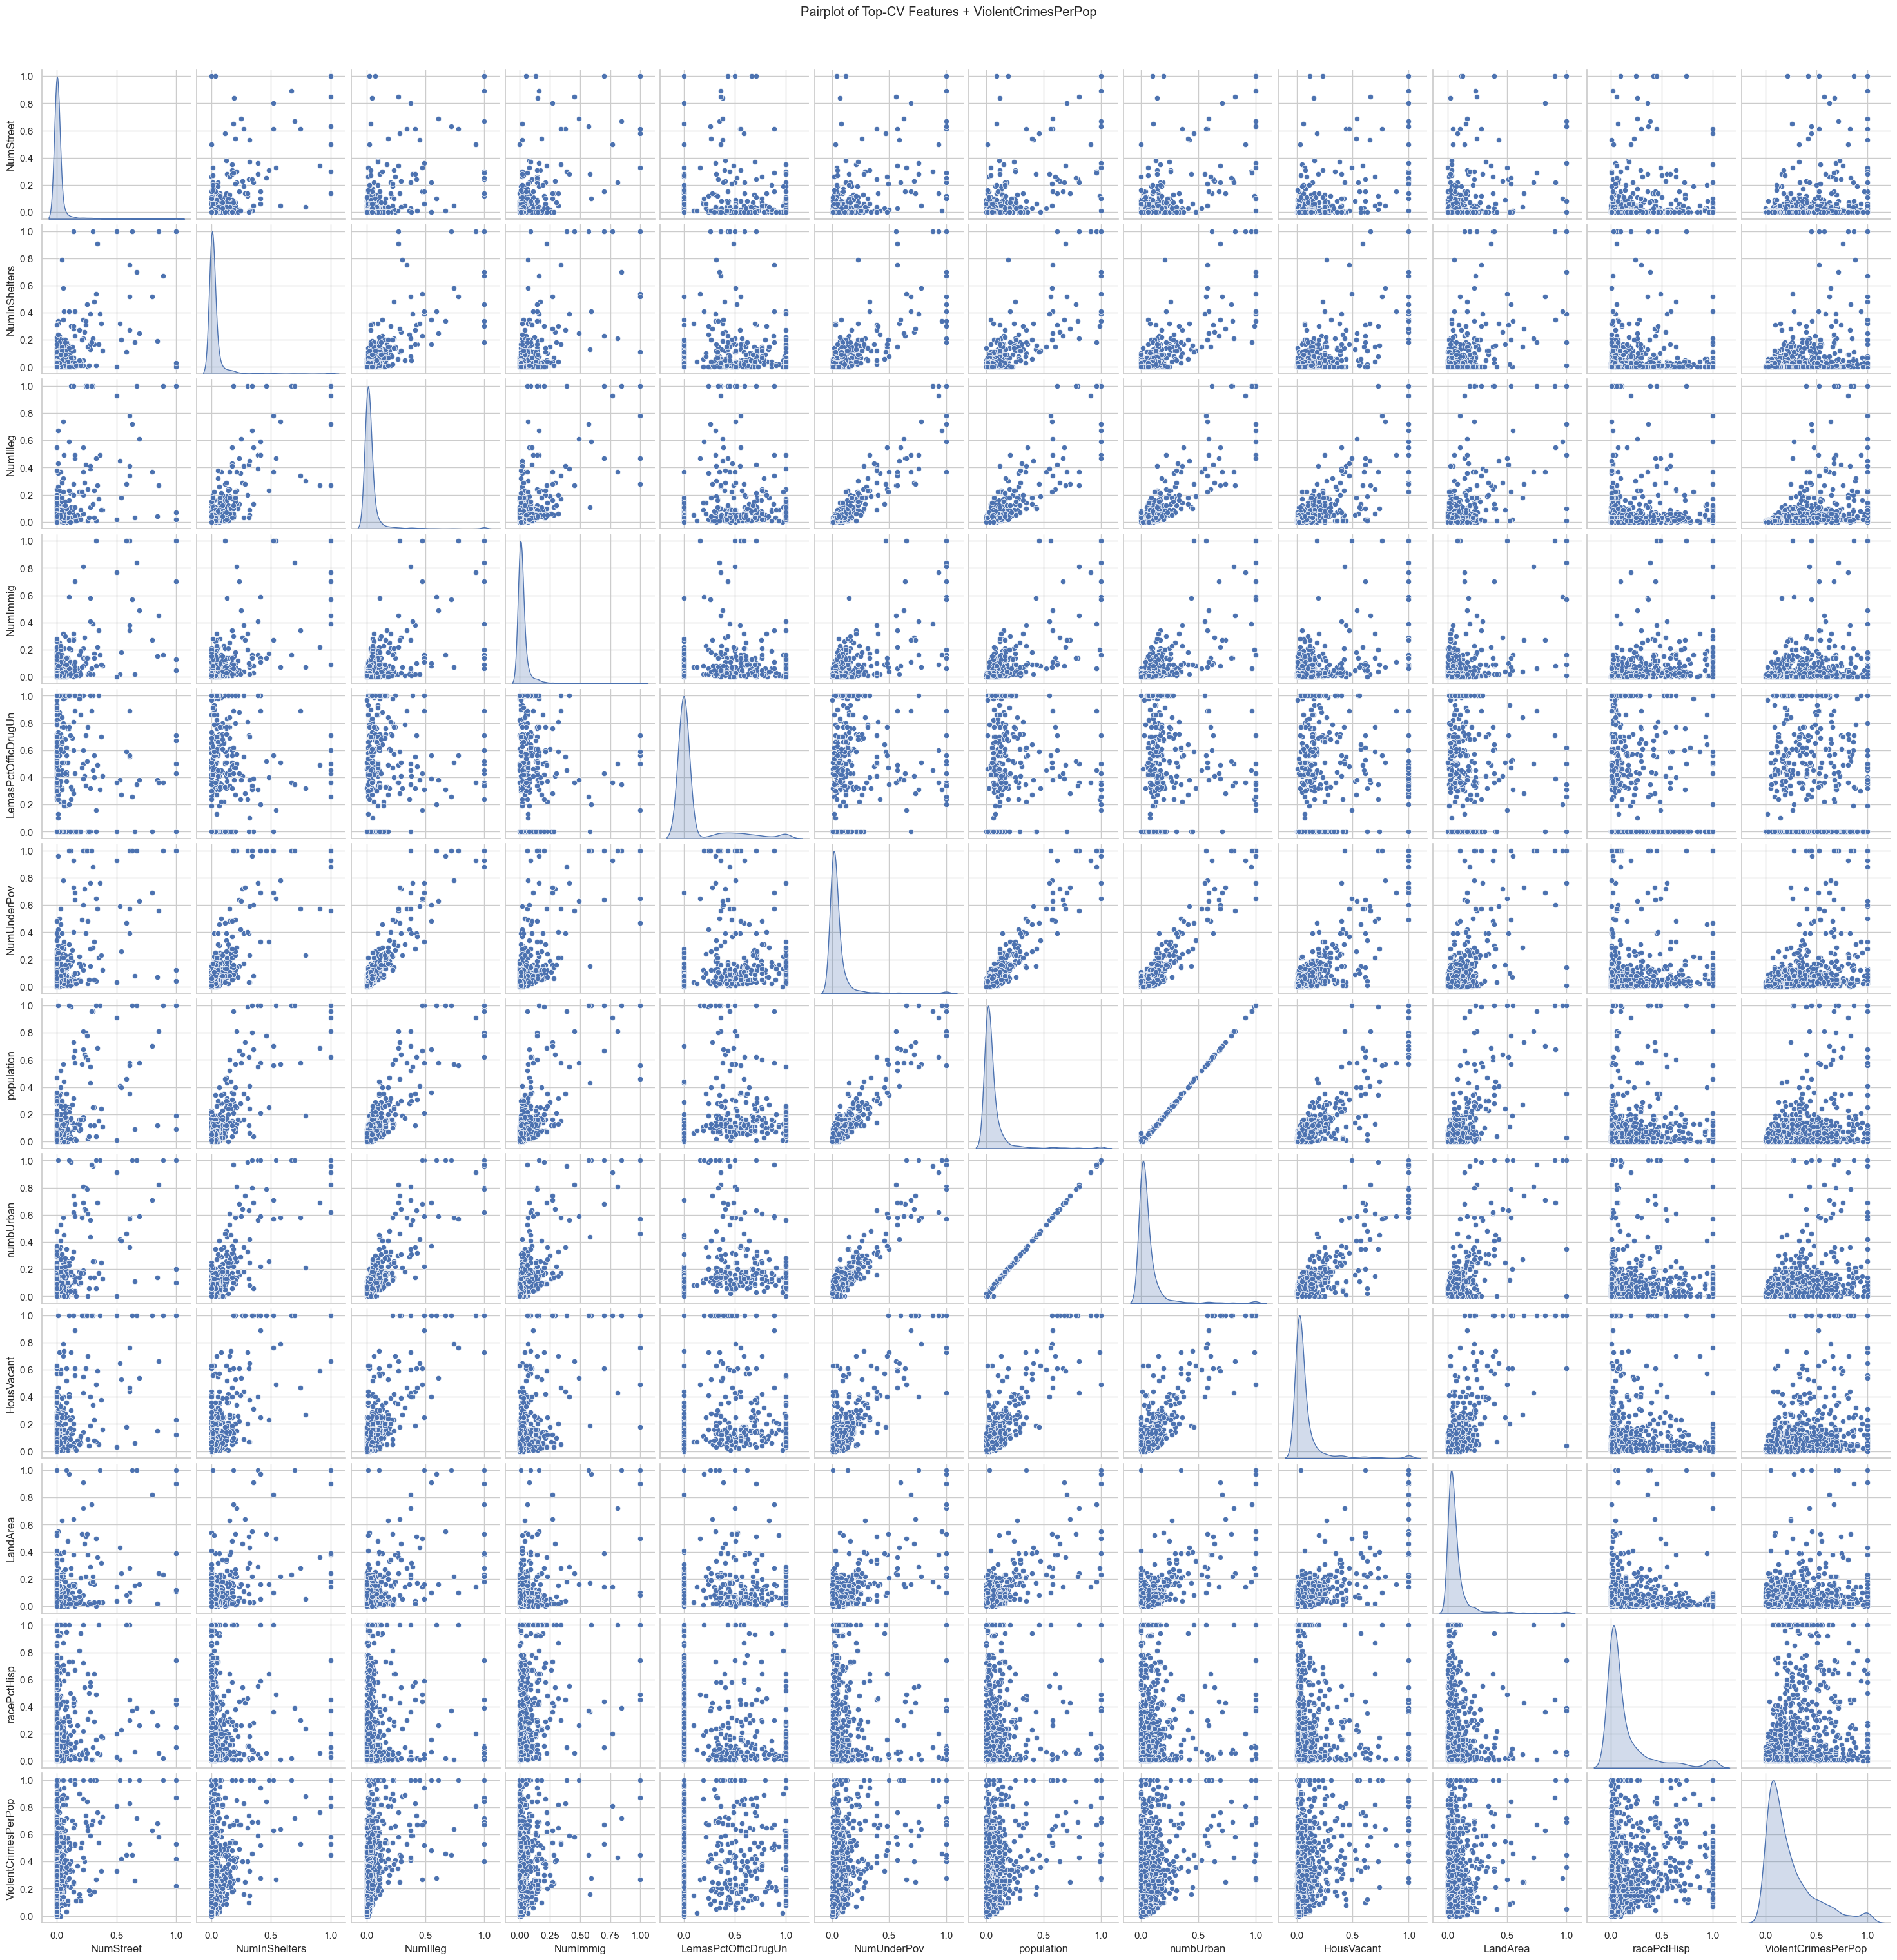

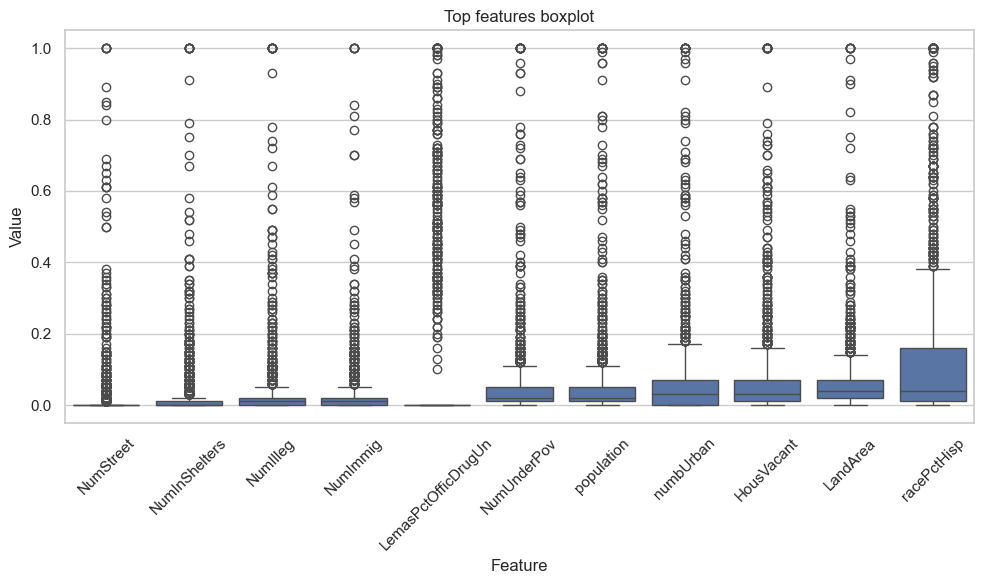

In [556]:
top_k = floor(sqrt(128))  # 11 for b=1
sorted_cv = sorted(cv_values.items(), key=lambda x: x[1], reverse=True)
top_features = [feat for feat, val in sorted_cv[:top_k]]

print("\nTop features by CV (k={}):".format(top_k))
for i, (feat, val) in enumerate(sorted_cv[:top_k], 1):
    print(f"{i}. {feat}: CV={val:.3f}")

#create a df of these top features + the target for visualization
viz_cols = top_features + [target_col]
df_viz = df_train[viz_cols].copy()

sns.set(style="whitegrid")
sns.pairplot(df_viz, diag_kind='kde', corner=False)
plt.suptitle("Pairplot of Top-CV Features + ViolentCrimesPerPop", y=1.02)
plt.show()

df_melted = df_viz[top_features].melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Feature', y='Value')
plt.title("Top features boxplot")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the scatterplots/pairplot, you can spot potential relationships between each feature and ViolentCrimesPerPop. However, these plots alone don't prove whether a feature is statistically significant or truly important for predicting crime rates. 

f. Linear Model Using Least Squares

In [557]:
x_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1:]
x_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1:]

x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()

#testing mse
x_test = sm.add_constant(x_test)
y_pred = model.predict(x_test)
mse_test = round(mean_squared_error(y_test, y_pred), 5)

print("MSE Error: ", mse_test)

MSE Error:  0.78973


g. Ridge Regression with Cross-Validation

In [558]:
alphas = np.logspace(-3, 3, 50)

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(x_train, y_train)

#predict on test set
y_pred_ridge = ridge_cv.predict(x_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"Best alpha (via CV): {ridge_cv.alpha_:.6f}")
print(f"Test MSE: {mse_ridge:.5f}")

Best alpha (via CV): 2.023590
Test MSE: 0.01762


h. LASSO With Cross-Validation

In [559]:
lasso_cv_unscaled = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso_cv_unscaled.fit(x_train, y_train)

y_pred_lasso_unscaled = lasso_cv_unscaled.predict(x_test)
mse_lasso_unscaled = mean_squared_error(y_test, y_pred_lasso_unscaled)

print("\nUnstandardized")
print(f"Best alpha (CV): {lasso_cv_unscaled.alpha_:.6f}")
print(f"Test MSE: {mse_lasso_unscaled:.5f}")

coef_mask_unscaled = (lasso_cv_unscaled.coef_ != 0)
selected_features_unscaled = x_train.columns[coef_mask_unscaled]
print(f"Number of features selected: {len(selected_features_unscaled)}")
print("Selected features:", list(selected_features_unscaled))

#LASSO on Standardized Data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

lasso_cv_scaled = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso_cv_scaled.fit(x_train_scaled, y_train)

y_pred_lasso_scaled = lasso_cv_scaled.predict(x_test_scaled)
mse_lasso_scaled = mean_squared_error(y_test, y_pred_lasso_scaled)

print("\nStandardized")
print(f"Best alpha (CV): {lasso_cv_scaled.alpha_:.6f}")
print(f"Test MSE: {mse_lasso_scaled:.5f}")

#selected variables in the standardized model
coef_mask_scaled = (lasso_cv_scaled.coef_ != 0)
selected_features_scaled = x_train.columns[coef_mask_scaled]
print(f"Number of features selected: {len(selected_features_scaled)}")
print("Selected features:", list(selected_features_scaled))


Unstandardized
Best alpha (CV): 0.001000
Test MSE: 0.01755
Number of features selected: 23
Selected features: ['racepctblack', 'racePctWhite', 'agePct12t29', 'pctUrban', 'pctWPubAsst', 'AsianPerCap', 'MalePctDivorce', 'PctKids2Par', 'PctYoungKids2Par', 'PctWorkMom', 'PctIlleg', 'PctRecImmig10', 'PctPersDenseHous', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'MedRentPctHousInc', 'MedOwnCostPctIncNoMtg', 'NumStreet', 'PctForeignBorn', 'PctSameCity85', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn']

Standardized
Best alpha (CV): 0.001000
Test MSE: 0.01776
Number of features selected: 68
Selected features: ['racepctblack', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par'

i. Principal Component Regression (PCR)

In [560]:
def evaluate_pcr(n_components_list, X_train, y_train, X_test, y_test):
    results = []
    for k in n_components_list:
        #build pipeline: PCA to LinearRegression
        pcr_pipeline = Pipeline([
            ('pca', PCA(n_components=k, random_state=42)),
            ('linreg', LinearRegression())
        ])
        pcr_pipeline.fit(X_train, y_train)
        y_pred = pcr_pipeline.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results.append((k, mse))
    return results

#standardize before PCA
X_train_scaled = scaler.fit_transform(x_train)  # reuse 'scaler' or create a new one
X_test_scaled = scaler.transform(x_test)

n_components_list = range(1, 21)
pcr_results = evaluate_pcr(n_components_list, X_train_scaled, y_train, X_test_scaled, y_test)

#find the best number of components
best_k, best_mse = min(pcr_results, key=lambda x: x[1])
print("\nPCR Model")
for k, mse_val in pcr_results:
    print(f"k={k}, MSE={mse_val:.5f}")

print(f"\nBest number of components: {best_k}")
print(f"PCR: Test MSE={best_mse:.5f}")


PCR Model
k=1, MSE=0.02801
k=2, MSE=0.02497
k=3, MSE=0.02334
k=4, MSE=0.02335
k=5, MSE=0.02267
k=6, MSE=0.02265
k=7, MSE=0.02240
k=8, MSE=0.01906
k=9, MSE=0.01800
k=10, MSE=0.01810
k=11, MSE=0.01811
k=12, MSE=0.01812
k=13, MSE=0.01807
k=14, MSE=0.01811
k=15, MSE=0.01792
k=16, MSE=0.01787
k=17, MSE=0.01769
k=18, MSE=0.01773
k=19, MSE=0.01768
k=20, MSE=0.01766

Best number of components: 20
PCR: Test MSE=0.01766


j. L1-Penalized Gradient Boosting

In [561]:
xgb_estimator = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

param_grid = {
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
}

grid_search = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
print("\nL1-Penalized Gradient Boosting")
print("Best Params:", grid_search.best_params_)

#evaluate on test set
y_pred_xgb = best_model.predict(X_test_scaled)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"Test MSE: {mse_xgb:.5f}")


L1-Penalized Gradient Boosting
Best Params: {'reg_alpha': 1}
Test MSE: 0.01776
